# Hyperparameter Tuning

## Tuning Process
- Hyperparameters
    - $\alpha$
    - $\beta$ (momentum GD)
    - $\beta_{1}, \beta_{2}, \epsilon$ (RMSprop, Adam)
    - \# layers
    - \# hidden units
    - Learning rate decay
    - Mini-batch size

- Roughly, we tune them in the order of red -> yellow -> purple -> else.



- How to select the set of values for hyperparameter tuning?
    - **Try RANDOM values: don't use a grid!**
        - This allows you to more richly explore set of possible values for the most important hyperparameters.
    - **Coarse to fine**
        - Zoom in to a smaller set of values after searching over a larger set.

## Using an Appropriate Scale to Pick Hyperparameters
- Picking hyperparameters at random deosn't mean uniformly random. Instead, we need appropriate scales to randomly pick values from.
- E.g. Let's assume we want to search random values for learning rate $\alpha = 0.0001, ..., 1$.
    - If picking uniformly random values, we'll only delegate a very small possibility to search between 0.0001 and 0.1.
    - What we should do instead, is to search uniformly among 0.0001, 0.001, 0.01, 0.1, and 1.
        - `r = -4 * np.random.rand()`
        - `learning_rate = 10 ** r`
        
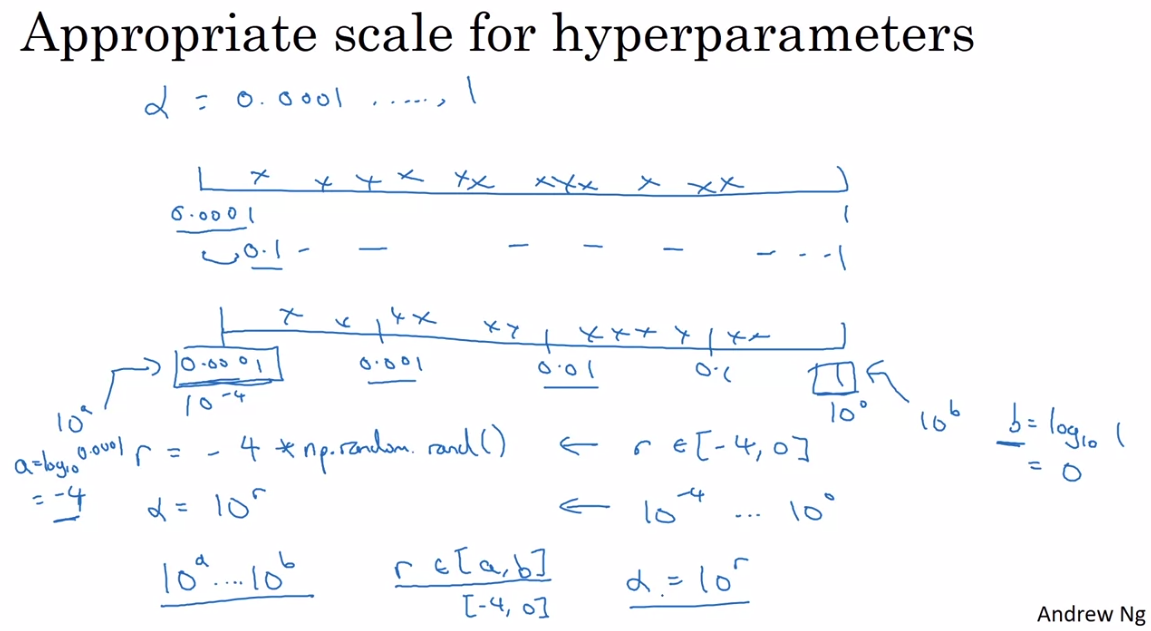

- Hyperparameters for Exponentially Weighted Averages
    - Suppose we want to search over $\beta = 0.9, ..., 0.999$.
        - However, it's a bad idea to sample over the linear scale from 0.9 to 0.999, because when $\beta$ gets closer to 1, $\frac{1}{1 - \beta}$ gets more sensitive to small changes in $\beta$.
        - Instead, we sample $1 - \beta$ as below:
            - $r \in [-3, -1]$
            - $1 - \beta = 10^{r}$
            - $\beta = 1 - 10^{r}$
        - Using this method, we sample more densely in the region of when $\beta$ is close to 1.

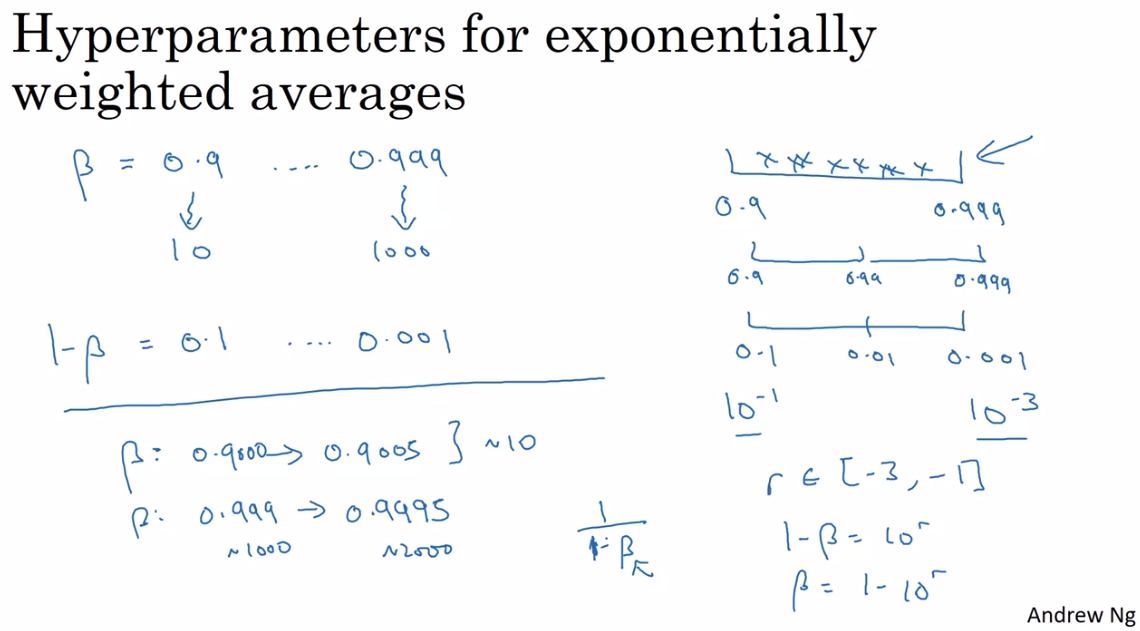

## Hyperparameters Tuning in Practice: Pandas vs. Caviar
- Re-test hyperparameters occasionally
    - Intuitions do get stale
    - Re-evaluate occasionally
- Approaches
    - Babysitting one model
    - Training many models in parallel
    
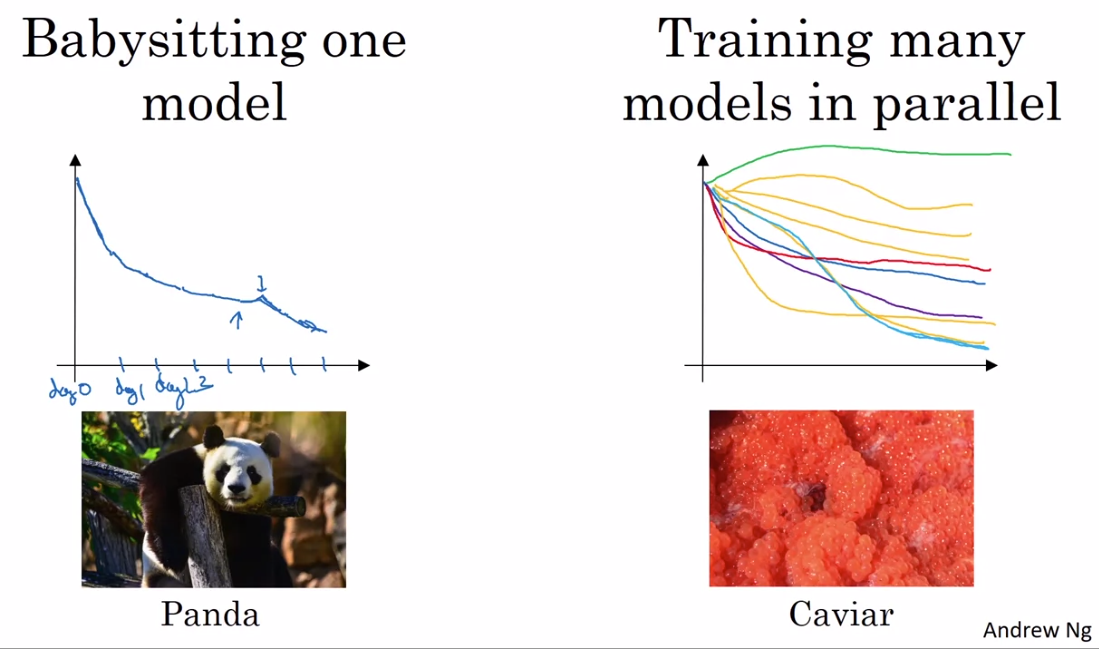

# Batch Normalization

## Normalizing Activations in a Network
- Batch Normalization makes hyperparamter tuning more robust and makes it easier to train deep neural networks.
- Previously, we learned to normalize inputs $X$ to speed up learning.
    - For a deeper neural network, can we normalize $a^{[l-1]}$ to train $W^{[l]}$ and $b^{[l]}$ faster? 
    - In practice, we can actually normalize $z^{[l-1]}$ before activation.
- Implementing Batch Normalization
    - Given the intermediate values on layer $l$ - $z^{(1)}, ..., z^{(n)}$
    - $\mu = \frac{1}{n} \sum_{i} z^{(i)}$
    - $\sigma^{2} = \frac{1}{n} \sum_{i} (z^{(i)} - \mu)^{2}$
    - $z^{(i)}_{norm} = \frac{z^{(i)} - \mu}{\sqrt {\sigma^{2} + \epsilon}}$
    - $\tilde z^{(i)} = \gamma z^{(i)}_{norm} + \beta$, where $\gamma$ and $\beta$ are learnable parameters in GD
        - Usually, we don't want to force zero-mean and 1-variance for the $z^{(i)}_{norm}$, because activation functions may have small slopes when $z^{(i)}_{norm}$ are close to 0.
    - Feed $\tilde z^{(i)}$ instead of $z^{(i)}$ to the activation function
    
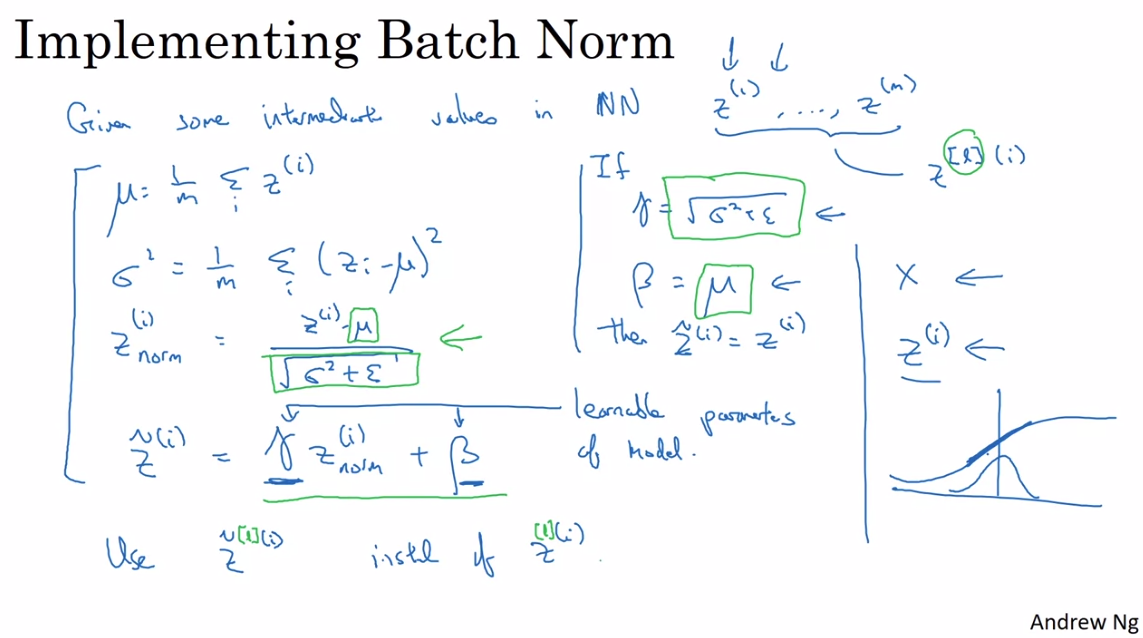

## Fitting Batch Norm into a Neural Network
- When implementing batch normalization (BN) to a neural network, we will have additional parameters needed to generate $\tilde z^{[l]}$:
    - $\gamma^{[l]}, l=1, ..., L$
    - $\beta^{[l]}, l=1, ..., L$
- We can optimize $\gamma^{[l]}$ and $\beta^{[l]}$ in backpropagation using the same optimization algorithms as for $W^{[l]}$ and $b^{[l]}$:
    - $\gamma^{[l]} := \gamma^{[l]} - \alpha d\gamma^{[l]}$
    - $\beta^{[l]} := \beta^{[l]} - \alpha d\beta^{[l]}$
- **Working with Mini-Batches**
    - When working with mini-batches, $z^{[l]}$ are normalized only based on the current mini-batch.

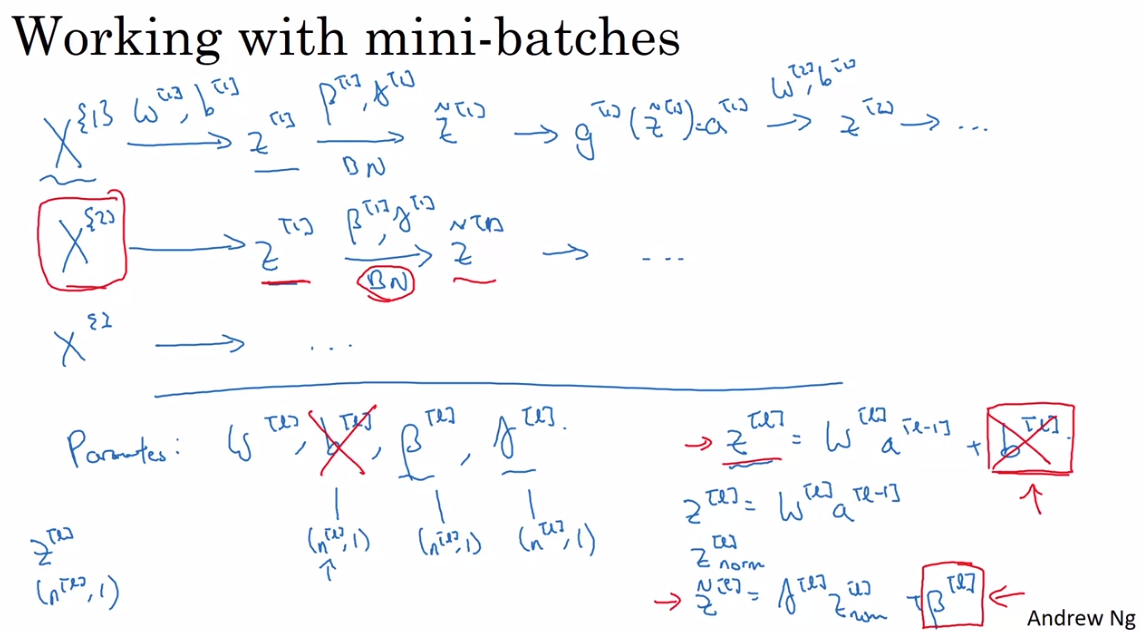

- A side note is that because $z^{[l]}$ are normalized and then rescaled using $\gamma^{[l]}$ and $\beta^{[l]}$, the original parameters in the neural network $b^{[l]}$ actually has no influence on the final output.

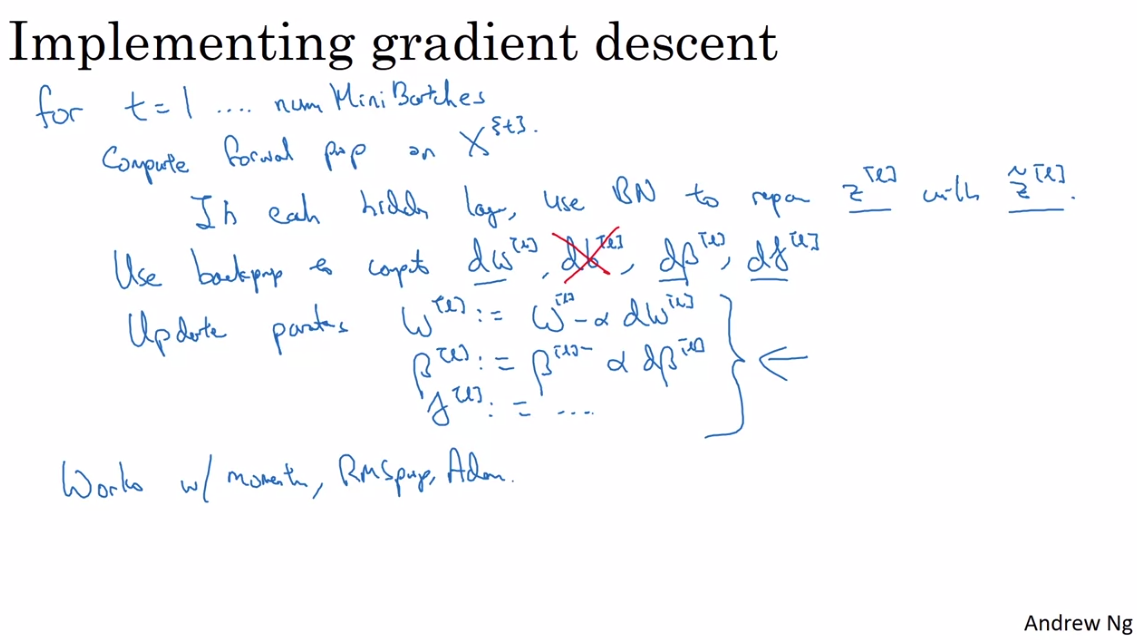

## Why Does Batch Normalization Work?
- The Problem of **Covariate Shift**
    - When training a deep neural network, all the parameters $\{ W^{[l]}, b^{[l]} \}, l = 1, ..., l^{*}$ are getting updated all the time.
    - As a result, $a^{[l^{*}]}$, which is then fed into layer $l^{*} + 1$, has a changing distribution, deteriorating the training of $\{ W^{[l]}, b^{[l]} \}, l = l^{*} + 1, ..., L$.
    - Batch Normalization reduces the value by which these hidden units shifts around.
        - Batch Normalization ensures that $ \tilde z^{[l]}$ always has the same mean and variance, no matter how many times the parameters have been updated.
        - As a result, outputs from each hidden layer is more stablized, and each layer can learn more independently.
        
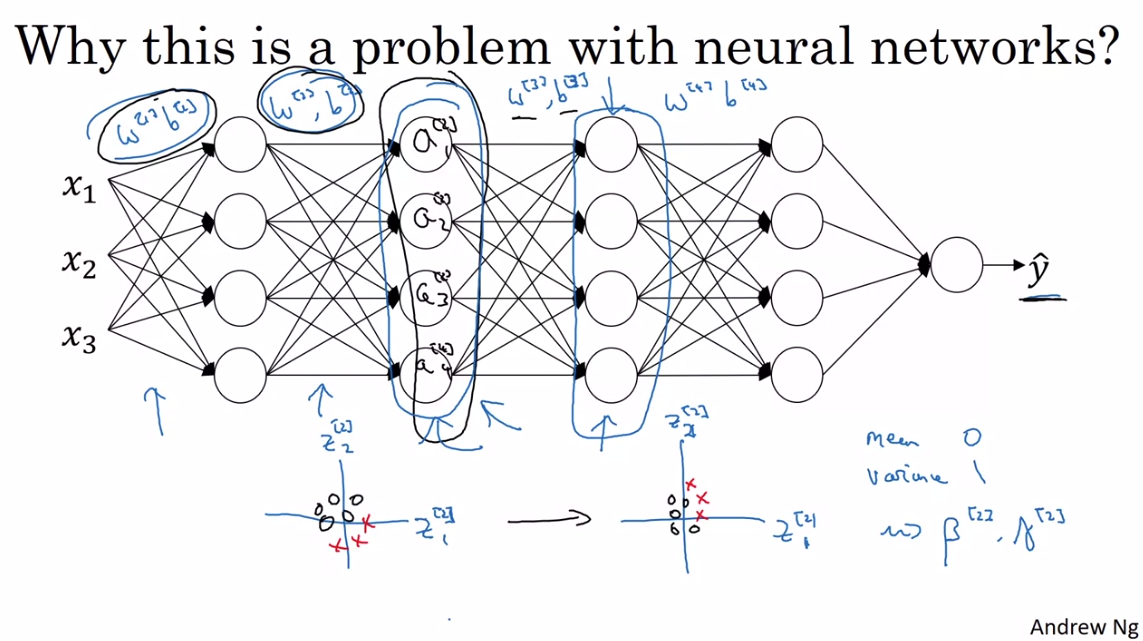

- Batch Norm as Regularization
    - This is an unintended side-effect of Batch Norm.
    - Also note that, the bigger the mini-batch size is, the less regularization effect it has.

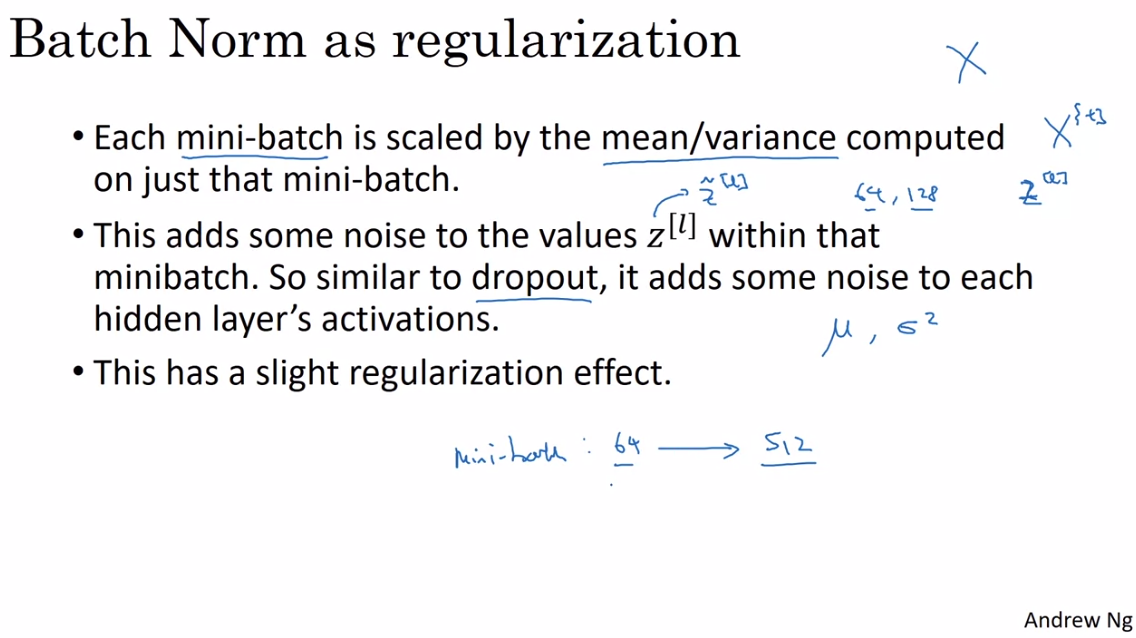

## Batch Norm at Test Time
- Recall batch norm at training time:
    - Given the intermediate values on layer $l$ - $z^{(1)}, ..., z^{(n)}$
    - $\mu = \frac{1}{n} \sum_{i} z^{(i)}$
    - $\sigma^{2} = \frac{1}{n} \sum_{i} (z^{(i)} - \mu)^{2}$
    - $z^{(i)}_{norm} = \frac{z^{(i)} - \mu}{\sqrt {\sigma^{2} + \epsilon}}$
    - $\tilde z^{(i)} = \gamma z^{(i)}_{norm} + \beta$, where $\gamma$ and $\beta$ are learnable parameters in GD
- Note that if we are using BN with mini-batches for training, $\mu$ and $\sigma^{2}$ are generated only using $X^{\{ t \}}$.
- At test time, we have to go through one testing example at each time and need to come up with $\mu$ and $\sigma^{2}$ in a different way.
    - We estimate $\mu$ and $\sigma^{2}$ using **exponentially weighted average** (across mini-batches).
        - We keep tracking $\mu^{\{ 1 \} [l]}, \mu^{\{ 2 \} [l]}, ...$ and $\sigma^{2 \{ 1 \} [l]}, \sigma^{2 \{ 2 \} [l]}, ...$ and then use them to generate running average estimates.
        
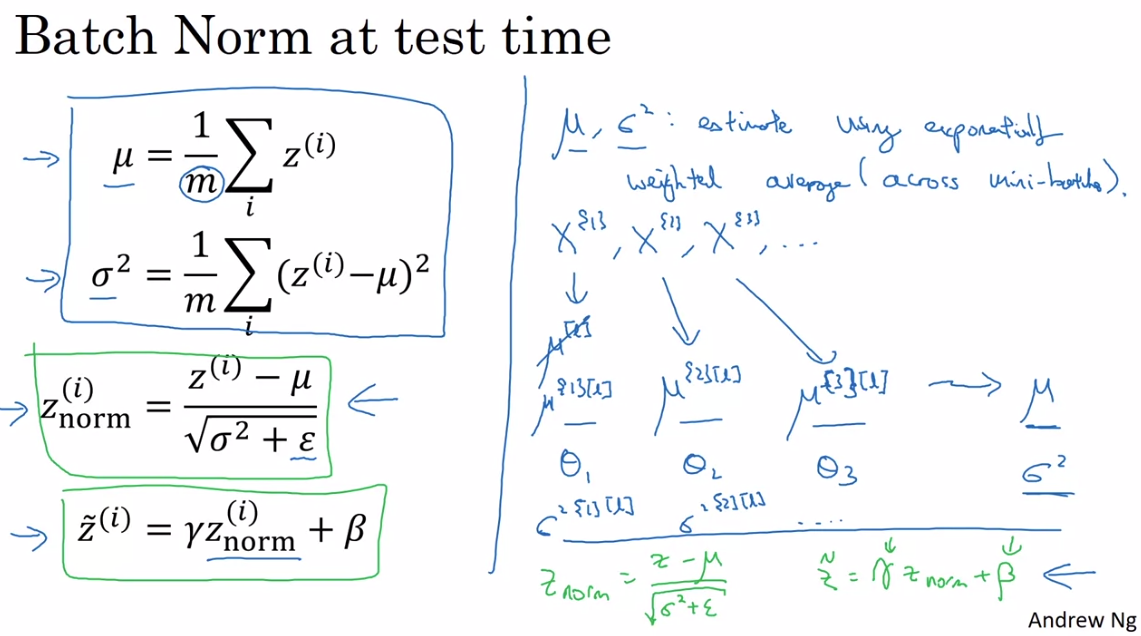

# Multi-Class Classification

## Softmax Regression
- Let $C$ = # classes
    - Then we'll have a neural network with $n^{[L]} = C$.
    - The output $\hat y$ has dimension $(C, 1)$, i.e. the probability of being each class.
- Softmax Layer
    - $Z^{[L]} = W^{[L]} a^{[L-1]} + b^{[L]}$
    - Activation function:
        - $t^{[L]} = e^{Z^{[L]}}$
        - $a^{[L]} = \frac{t^{[L]}}{\sum_{i=1}^{C} t_{i}^{[L]}}$
    - Thus, the softmax activation function takes in a $(C, 1)$ vector and outputs a $(C, 1)$ vector. 
        
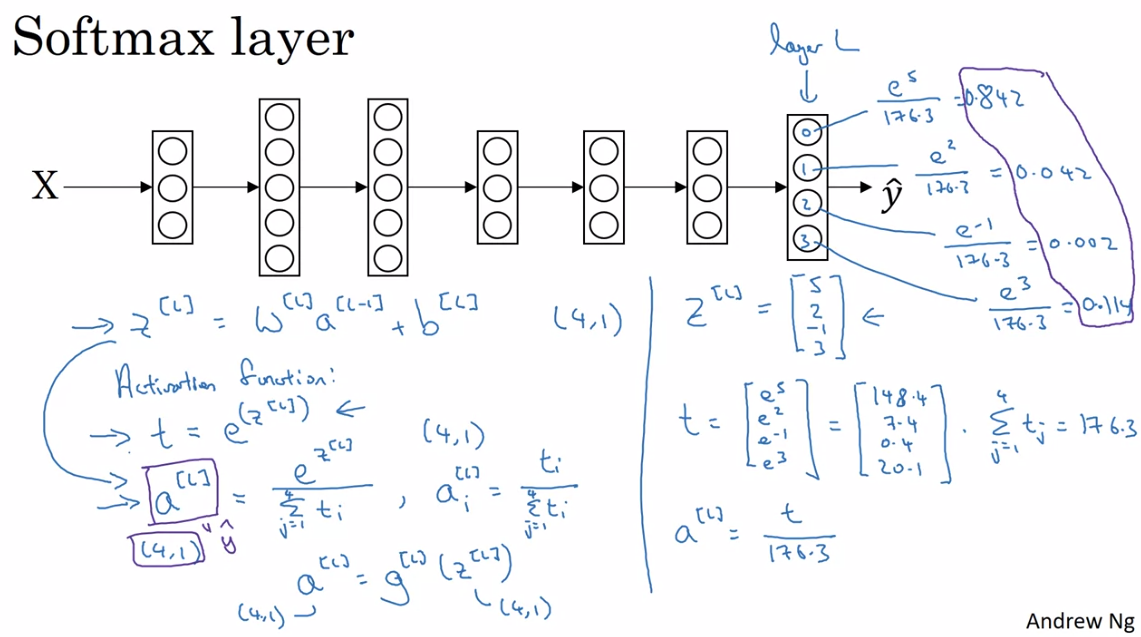

- The decision boundary between any two classes is linear.

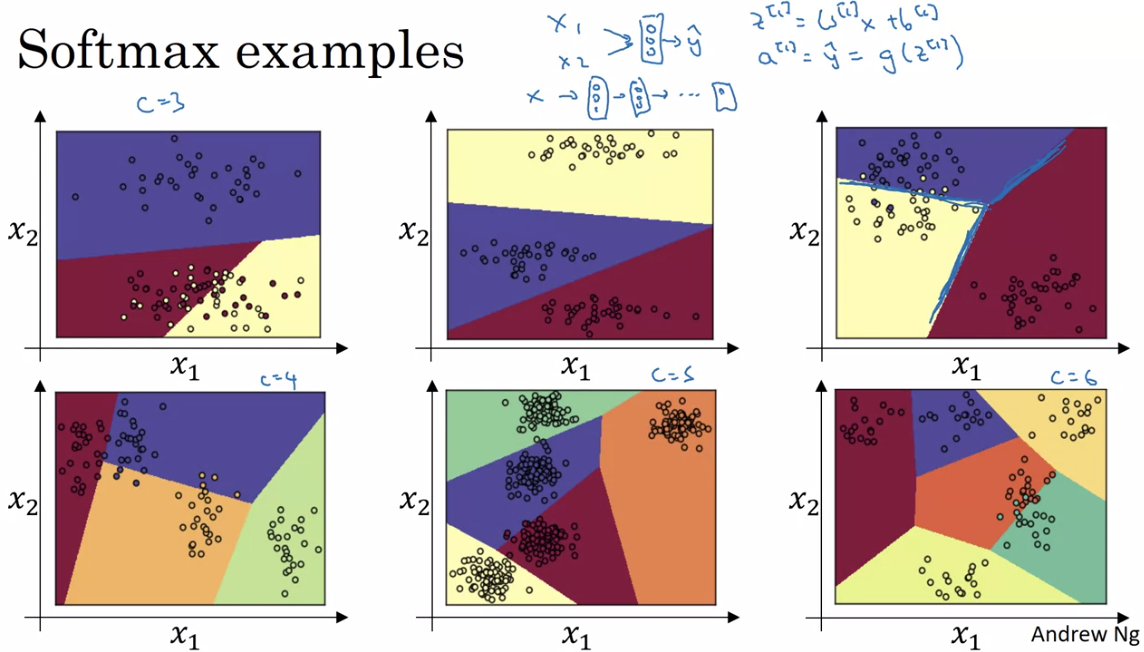

## Training a Softmax Classifier



- Loss Function
    - $L(\hat y, y) = -\sum_{j=1}^{C} y_{j} log(\hat y_{j})$
- Cost Function
    - $J(W^{[1]}, b^{[1]}, ...) = \frac{1}{m} \sum_{i=1}^{m} L(\hat y_{i}, y_{i})$
    
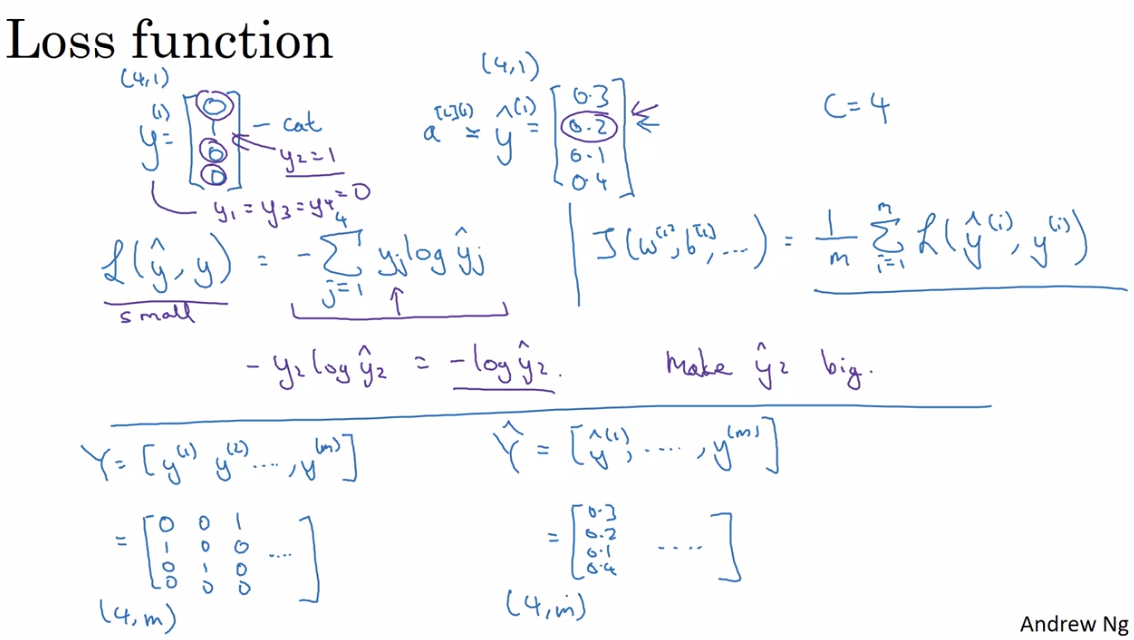

# Introduction to Programming Frameworks

## Deep Learning Frameworks



## TensorFlow
- Sample Problem - use TensorFlow to minimize the following cost function:
    - $J(w) = w^{2} - 10w + 25$

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
w = tf.Variable(0, dtype=tf.float32)
# cost = tf.add(tf.add(w**2, tf.multiply(-10., w)), 25)
cost = w**2 - 10*w + 25
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

In [7]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)
print(session.run(w))

0.0


In [8]:
session.run(train)
print(session.run(w))

0.099999994


In [9]:
for i in range(1000):
    session.run(train) # 1000 iterations of gradient descent
    
print(session.run(w))

4.9999886


- What if we have training data to feed into TensorFlow?

In [10]:
coefficients = np.array([[1.], [-10.], [25.]])
x = tf.placeholder(tf.float32, shape=[3, 1])
cost = x[0][0]*w**2 + x[1][0]*w + x[2][0]

In [11]:
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

In [12]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)
print(session.run(w))

0.0


In [13]:
session.run(train, feed_dict={x: coefficients})
print(session.run(w))

0.099999994


In [14]:
for i in range(1000):
    session.run(train, feed_dict={x: coefficients}) # 1000 iterations of gradient descent
    
print(session.run(w))

4.9999886
